In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import correlate
from flecht import Simulator, TotalisticRule
import skimage.morphology as morph
import napari
import matplotlib.pyplot as plt
%gui qt
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
def randomPos(fielddims, seed_dims, num_seeds):
    # generate a tuple of (x,y) coordinates randomly selected with replacement
    # from within the bounds set by fielddims
    x = np.random.choice(fielddims[0], num_seeds, replace=True).clip(0, fielddims[0])
    y = np.random.choice(fielddims[1], num_seeds, replace=True).clip(0, fielddims[1])
    
    return zip(x,y)

In [27]:
def randomNb(dims, totals, neg_mask = None, pos_mask = None):
    # return a binary neighborhood with size = dims and summing to one of the values in totals    
    # negative mask is applied before positive mask
    
    nb = np.zeros([np.prod(dims),1])
    linear_inds = np.array(range(np.prod(dims)))
        
    if neg_mask is not None:
        linear_inds = linear_inds[neg_mask.ravel()]
    
    if pos_mask is not None:
        nb[pos_mask.ravel()] = 1
        #linear_inds = linear_inds[np.logical_not(pos_mask.ravel())]
    
    if isinstance(totals, int):
        totals = [totals]
    
    total = np.random.choice(totals, 1)    
    
    active = np.random.choice(linear_inds, total, replace=False)
    nb[active] = 1
    nb = nb.reshape(dims)
    
    return nb.astype('int')

In [111]:
# set number of states and generate neighborhoods
nStates = 3
nb_dims = [3,3]
center = [n // 2 for n in nb_dims]
neg_mask = np.ones(nb_dims, dtype='bool')
pos_mask = np.ones(nb_dims, dtype='bool')

# make a hole in the center of each nb
#neg_mask[nb_dims[0] // 2, nb_dims[1] // 2] = 0
# confine behavior to 1.5 dimensions
#neg_mask[:nb_dims[0]//2,:] = 0
# a positive mask the fills regions near the center of nb
#pos_mask[:,:] = 1
pos_mask[center] = 0
#pos_mask[0,2] = 0
#pos_mask[:,-1] = 0
#pos_mask[1:, 0] = 1

pos_mask = pos_mask.astype('bool')
#pos_mask = None
nbs = []
for x in range(nStates):
    nb = randomNb(nb_dims, [0], neg_mask = neg_mask, pos_mask = pos_mask)
    nbs.append(xr.DataArray(nb))

def stability_fun(t, v, interval=10, nStates=nStates):
    if t % interval == 0:
        from numpy import array_equal
        result = array_equal(v[t], v[t-1])
        if result:
            return result
        else:
            result = array_equal(v[t], v[t-nStates])
        return result


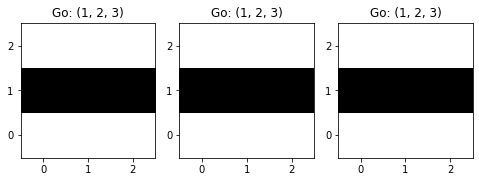

In [112]:
# set up go rules
from itertools import combinations
from functools import reduce
from operator import add
num_rules = np.max([nb.sum() for nb in nbs])
all_rules = [list(combinations(range(1,num_rules+1), r)) for r in range(1, num_rules+1)]
all_rules_flat = list(reduce(add, all_rules))
gos = nStates * [all_rules[2][0]]

if len(nb_dims) == 2:

    # plot neighborhoods and display go rules
    plt_x  = 9
    plt_y = int((nStates + (plt_x - 1) * (nStates % plt_x)) / plt_x)

    plt.figure(figsize=(20,20))
    for ind, nb in enumerate(nbs):
        plt.subplot(plt_y, plt_x, ind+1)
        plt.imshow(nb, interpolation='None', cmap='gray', origin='lower', clim=(0,1))
        plt.xticks(np.arange(nb.shape[1]))
        plt.yticks(np.arange(nb.shape[0]))
        plt.title('Go: {0}'.format(gos[ind]))
    plt.tight_layout()

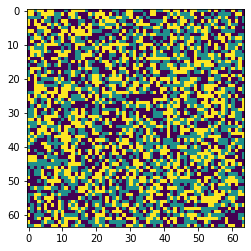

In [113]:
# generate initialization
fdims = (64,) * len(nb_dims)
field = xr.DataArray(np.random.randint(0, nStates, fdims))
#field = np.zeros(fdims)
#field[field.shape[0]//2, field.shape[1]//2] = 1
if len(nb_dims) == 2:
    plt.imshow(field)

In [115]:
def runsim(field, rules, trange):
    sim = Simulator(rules, trigger_state=0)
    vol = sim.run(field, stability_func=stability_fun, num_iter=len(trange))    
    return np.vstack([np.asarray(field)[np.newaxis,...], vol])

In [116]:
tRange = range(1000)
curField = field
rules = [list(map(TotalisticRule, nbs, nStates * [gos])) for gos in all_rules_flat]
results = [runsim(field, rule, tRange) for rule in rules]
sort = np.argsort([len(np.where(r.std((1,2)) == 0)[0]) for r in results])
# sort by duration
vols = np.array(results)[sort]

In [0]:
for ind, val in enumerate(np.array(all_rules_flat)[sort]):
    print(ind, val)

In [110]:
with napari.gui_qt():
    napari.view_image(vols, contrast_limits=(0,nStates-1))

In [ ]:
from skimage.util import montage
# to_tile = vol[np.linspace(0, terminus, 16).astype('int')]
to_tile = vols[64][30:46].copy()
for ind,t in enumerate(to_tile):    
    to_tile[ind] = t + ind 
mont = montage(to_tile, grid_shape=(4,4))
fig = plt.figure(dpi=300)
axs = fig.add_axes((0,0,1,1))
plt.imshow(mont, cmap='tab20b')
axs.axis('off')

In [ ]:
fig, axs= plt.subplots(dpi=200)
axs.plot(vols.mean((2,3)).T);

In [ ]:
from fish.util.plot import depth_project
import matplotlib
fig = plt.figure(dpi=200, facecolor='k')
axs = fig.add_axes((0,0,1,1))
axs.axis('off')
axs.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
axs.yaxis.set_major_locator(matplotlib.ticker.NullLocator())
axs.imshow(depth_project(vol[:terminus], mode='max', cmap='rainbow')[:,:,:-1])

In [ ]:
tmp = np.fft.fftshift(np.real(np.conj(np.fft.fft2(vol)) * np.fft.fft2(vol)))
flk.window.Window((np.log(1 + tmp)))

In [ ]:
fig = plt.figure(figsize=(4,4))
axs = fig.add_axes([0,0,1,1])
cmap='gray'
fname = 'demo.m4v'
toPlot = vol
t_end = vol.shape[0]
tRange = range(t_end)
im = axs.imshow(toPlot[tRange[0]], cmap=cmap, interpolation='None', clim=[0,nStates-1])
plt.axis('off')

def updatefig(t):                
    im.set_array(toPlot[t])    
                                    
ani = animation.FuncAnimation(fig, updatefig, tRange, interval=100
                              , blit=False)
writer = animation.writers['ffmpeg'](fps = 16, codec = 'h264', extra_args=['-pix_fmt', 'yuv420p'])
ani.save(fname, writer=writer, dpi = 100)